#**Poisson Regression**
In probability theory and statistics, the Poisson distribution was discovered by Siméon Denis Poisson. It is a discrete probability distribution that expresses the probability of a given number of events occurring in a fixed interval of time or space if these events occur with a known constant mean rate and independently of the time since the last event, [1]. The Poisson distribution comes from the exponential family of distributions and has the following discrete probablitity density function for a random variable $X$ :

$$f(k,\lambda) = Pr(X=k)= \frac{\lambda^k.e^{-\lambda}}{k!}$$

where $\lambda>0$ if for k=0,1,2,..
and the $E(X)=\lambda$ and the variance is also equal to $\lambda$

Typical examples of this would be counting the number of road accidents on a particular stretch of road during a time interval. We could then use the poisson to calcualte the probability of $k$ number of accidents in the time interval. The $\lambda$ is usually desctribed as the average number of accidents in a time interval, eg the average number per week.. It also assumes we have no information about the sample size $N$. In theory as $N->\infty$ the binomal distribution tends to the poisson distribution.The possion distribution is a special case of another distribution exponential distribution called the negative binomial distribution, which does not assume you have a constant variance. Figure 1 shows the differing types of distribution in the GLM family. You will see how the poisson and the negative binomial have very simalar characteristics.

<figure>
<center>
<img src='https://www.computing.dcu.ie/~amccarren/mcm_images/GLM_models.png' />
<figcaption>Figure 2: Link function options</figcaption>
</center>
</figure>


Now we regulary count, for example, the number of events in a month or a week . In many situations we have predictor variables that we want to use to predict these events. For example consider the situation we mentioned before about the number of road accidents on a given stretch of road. It would be reasonable for the road authority to wonder if weather conditions, speed limit or the time of the day had any influence on the number of accidents in a given period. This is where poisson regression comes in and we can use pythons GLM library to implement it.

Lets have a look at some python code.

**A Poisson regression model**

Count based data contains events that occur at a certain rate. The rate of occurrence may change over time or from one observation to next. Here are some examples of count based data:

* Number of vehicles crossing an intersection per hour,
* Number of people visiting a doctor’s office per month,
* Number of earth-like planets spotted per month.
* A data set of counts has the following characteristics:
* Whole number data: The data consists of non-negative integers: [0… ∞] Regression techniques such as Ordinary Least Squares Regression may not be appropriate for modeling such data as OLSR works best on real numbers such as -656.0, -0.00000345, 13786.1 etc.

* Skewed Distribution: The data may contain a large number of data points for just a few values, thereby making the frequency distribution quite skewed. See for example above histogram.
* Sparsity: The data may reflect the occurrence of a rare event such as a gamma ray burst, thereby making the data sparse.
* Rate of occurrence: For the sake of creating a model, it can be assumed that there is a certain rate of occurrence of events λ that drives the generation of such data. The event rate may drift over time.

Let us examine a more common situation, one where λ can change from one observation to the next. In this case, we assume that the value of λ is influenced by a vector of explanatory variables or predictors X. A poison regression approach could help us predict the the occurence count given certrian conditions or help us determine which variable may influence the outcome.

As usual by now we open up a folder on google drive use the mount drive method.



In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/My Drive/dcu/future Learn_v2/MOOC 5 - CA683 - Point Estimation and Future Impact Calculation/M5 Colab Files/Data")
!ls

Mounted at /content/drive
calories.csv			  poisson_predictions.csv
exercise.csv			  SN_m_tot_V2.0.csv
nyc_bb_bicyclist_counts.csv	  student_mat.csv
nyc_bb_bicyclist_counts_test.csv  Telco-Customer-Churn.csv


Import the data for this example from [here](https://www.computing.dcu.ie/~amccarren/mcm_data/nyc_bb_bicyclist_counts.csv). This is the Daily total of bike counts conducted on the Brooklyn Bridge from 01 April 2017 to 31 October 2017. Source: [NYC Open Data: Bicycle Counts for East River Bridges.](https://gist.github.com/sachinsdate/c17931a3f000492c1c42cf78bf4ce9fe).   In the NYC bicyclist counts data set, the regression variables are Date, Day of Week, High Temp, Low Temp and Precipitation. We also introduce additional regressors such as Month and Day of Month that are derived from Date, and we have the liberty to drop existing regressors such as Date.

In [ ]:
import pandas as pd
df = pd.read_csv('nyc_bb_bicyclist_counts.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])
print(df)

            HIGH_T  LOW_T  PRECIP  BB_COUNT
Date                                       
2017-04-01    46.0   37.0    0.00       606
2017-04-02    62.1   41.0    0.00      2021
2017-04-03    63.0   50.0    0.03      2470
2017-04-04    51.1   46.0    1.18       723
2017-04-05    63.0   46.0    0.00      2807
...            ...    ...     ...       ...
2017-10-27    62.1   48.0    0.00      3150
2017-10-28    68.0   55.9    0.00      2245
2017-10-29    64.9   61.0    3.03       183
2017-10-30    55.0   46.0    0.25      1428
2017-10-31    54.0   44.0    0.00      2727

[214 rows x 4 columns]


We extract the day, day of the week and  month from the date index.

In [ ]:
ds = df.index.to_series()
df['MONTH'] = ds.dt.month
df['DAY_OF_WEEK'] = ds.dt.dayofweek
df['DAY'] = ds.dt.day
#df.head()
#X=df[['HIGH_T', 'LOW_T', 'PRECIP',  'MONTH', 'DAY_OF_WEEK', 'DAY']]
X=df[['HIGH_T', 'LOW_T', 'PRECIP']]

y=df[["BB_COUNT"]]
df.head()


,HIGH_T,LOW_T,PRECIP,BB_COUNT,MONTH,DAY_OF_WEEK,DAY
Date,,,,,,,
2017-04-01,46.0,37.0,0.00,606,4,5,1
2017-04-02,62.1,41.0,0.00,2021,4,6,2
2017-04-03,63.0,50.0,0.03,2470,4,0,3
2017-04-04,51.1,46.0,1.18,723,4,1,4
2017-04-05,63.0,46.0,0.00,2807,4,2,5


We split the data into taining and test.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_test.head()
#y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
#y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

,BB_COUNT
Date,
2017-04-10,3324
2017-10-15,2169
2017-06-06,1193
2017-10-09,898
2017-07-27,3287


Then we run statsmodel GLM setting the family to poisson and use a log link function with the poisson family. It defaults to the identity so be careful if using it. Like all the other types of regression approaches we have used so far we get the model results with the parameters and their significance levels. From the analysis below we can see that the P-value for the $\chi^2$ is \< 0.05 indicating that the model is significantly away from the staturated model or the model is missing soemthing.

In [ ]:
import statsmodels.api as sm
from scipy.stats import chi2

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
link_func = sm.families.links.log()


poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson(link_func)).fit()

print("chi-square p-value test Ho model vs saturated model If < 0.05 reject Ho model is a poor fit. :",1-chi2.cdf(poisson_training_results.pearson_chi2,(poisson_training_results.df_resid-len(X_train.columns))))
print(poisson_training_results.summary())
#print(y.describe())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


chi-square p-value test Ho model vs saturated model If < 0.05 reject Ho model is a poor fit. : 0.0
                 Generalized Linear Model Regression Results                  
Dep. Variable:               BB_COUNT   No. Observations:                  171
Model:                            GLM   Df Residuals:                      167
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12497.
Date:                Sun, 27 Mar 2022   Deviance:                       23343.
Time:                        14:48:15   Pearson chi2:                 2.29e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  import sys


The model is far from ideal and this could be due to the assumption that in a poisson model the $\mu$ $=\sigma$. This does not seem to be the case when you run a pandas describe on the y dataframe.
————————————————————————————————————————————————————————————————

解读回归结果

所有变量的 p 值（P>|z|）都小于 0.05，说明它们都对因变量 BB_COUNT 具有统计显著性。
系数解释（用指数函数转换）：
高温（HIGH_T）增加 1 单位，BB_COUNT 预计增长
𝑒
0.0187
≈
1.0188
e
0.0187
 ≈1.0188 倍（约 1.88%）。
低温（LOW_T）增加 1 单位，BB_COUNT 预计减少
𝑒
−
0.0082
≈
0.9918
e
−0.0082
 ≈0.9918 倍（减少约 0.82%）。
降水（PRECIP）每增加 1 单位，BB_COUNT 预计减少
𝑒
−
0.9291
≈
0.395
e
−0.9291
 ≈0.395 倍（约减少 60.5%）。




在泊松分布（Poisson Distribution）中，它有一个特殊的性质：

𝐸
(
𝑋
)
=
𝜇
,
Var
(
𝑋
)
=
𝜎
2
=
𝜇
E(X)=μ,Var(X)=σ
2
 =μ


 即，泊松分布的均值等于方差。


 例子 假设某条道路上，每天发生平均
𝜆
=
3
λ=3 起交通事故：

这条路每天事故数
𝑋
X 服从泊松分布
𝑋
∼
Poisson
(
3
)
X∼Poisson(3)。
事故数的均值
𝐸
(
𝑋
)
=
3
E(X)=3。
事故数的方差
Var
(
𝑋
)
=
3
Var(X)=3。
即，事故数的波动程度和均值相等。

In [ ]:
poisson_predictions = poisson_training_results.get_prediction(X_test)

predictions_summary_frame = poisson_predictions.summary_frame().sort_index()
print(predictions_summary_frame.head())
#predictions_summary_frame.to_csv('poisson_predictions.csv')

                   mean    mean_se  mean_ci_lower  mean_ci_upper
Date                                                            
2017-04-10  3038.877337   8.590627    3022.086577    3055.761388
2017-04-16  3490.364671  13.107450    3464.768853    3516.149577
2017-04-17  2796.904450   5.247876    2786.637691    2807.209033
2017-04-19  2168.563695   8.475612    2152.015266    2185.239378
2017-04-26  1690.164080   6.383927    1677.698013    1702.722776


In the following code snippet we do a comparsion of the  actual counts vs the predicted counts. You can see the model is not really a good fit and would lead us to believe something is missing.

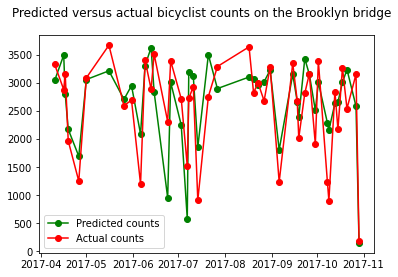

<Figure size 432x288 with 0 Axes>

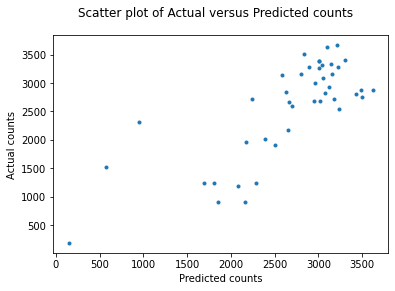

In [ ]:
import matplotlib.pyplot as plt
predicted_counts=predictions_summary_frame['mean']
y_test=y_test.sort_index()
X_test=X_test.sort_index()
#print(y_test['BB_COUNT'],predicted_counts)
actual_counts = y_test['BB_COUNT']
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()

References:

[1] Haight, F.A., 1967. Handbook of the Poisson distribution.